The Following paper has been implemented in this notebook: https://arxiv.org/abs/1706.03762

The dataset is different from that of the paper.

In [94]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.optim import lr_scheduler
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import imageio
import torchvision.transforms.functional as F
import torch.nn.functional as F1
import torchvision

In [95]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Loading Data

In [96]:
import json

f = open('/content/drive/MyDrive/DL/attention_data/two_digit_op.json')

#tokenize:
  
# returns JSON object as 
# a dictionary
data = json.load(f)
  
num_disp = 5
s = 0
# Iterating through the json
# list
print("no of input sequences: ", len(data['inp_expression']))
print("\ndisplaying {} input sequences: ".format(num_disp))

map_list = []
map_dict = {}

for i in data['inp_expression']:
  l = list(i.split(" "))
  for word in l:
    if word not in map_list:
      map_list.append(word)

for i in data['out_expression']:
  l = list(i.split(" "))
  for word in l:
    if word not in map_list:
      map_list.append(word)

t = 0
for i in map_list:
  map_dict[i] = t
  t += 1

for i in data['inp_expression']:
  s += 1
  print(i)
  if s >num_disp:
    break

print("---------------------------------------")
print("no of output sequences: ", len(data['out_expression']))
print("displaying {} output sequences: ".format(num_disp))
s = 0 
for i in data['out_expression']:
  print(i)
  s+= 1
  if s >num_disp:
    break
  
# Closing file
f.close()

no of input sequences:  5000

displaying 5 input sequences: 
BOS NEGATIVE 30 subtract NEGATIVE 34 EOS
BOS NEGATIVE 34 add NEGATIVE 15 EOS
BOS NEGATIVE 28 add NEGATIVE 36 EOS
BOS POSITIVE 00 subtract POSITIVE 17 EOS
BOS POSITIVE 16 add POSITIVE 09 EOS
BOS POSITIVE 23 add POSITIVE 15 EOS
---------------------------------------
no of output sequences:  5000
displaying 5 output sequences: 
BOS POSITIVE 04 EOS
BOS NEGATIVE 49 EOS
BOS NEGATIVE 64 EOS
BOS NEGATIVE 17 EOS
BOS POSITIVE 25 EOS
BOS POSITIVE 38 EOS


In [97]:
len(map_list)  #total no of words

104

In [98]:
#converting strings into sequence of tokens:
input = np.zeros((len(data['inp_expression']), 7))
output = np.zeros((len(data['out_expression']), 4))

for num, i in enumerate(data['inp_expression']):
  l = list(i.split(" "))
  for num1, word in enumerate(l):
    input[num, num1] = map_dict[word]

for num, i in enumerate(data['out_expression']):
  l = list(i.split(" "))
  for num1, word in enumerate(l):
    output[num, num1] = map_dict[word]

In [99]:
input[0]  #first input token

array([0., 1., 2., 3., 1., 4., 5.])

In [100]:
output[0]  #first output token

array([ 0., 10., 16.,  5.])

In [101]:
#Length of input and output arrays:
print("Length of input array: ", input.shape[0])
print("Length of output array: ", output.shape[0])

Length of input array:  5000
Length of output array:  5000


In [102]:
output.shape

(5000, 4)

In [103]:
if torch.cuda.is_available():
  print("cuda GPU is available")
  DEVICE = 'cuda'
else:
  print("GPU is not available")
  DEVICE = 'cpu'



cuda GPU is available


#Multi-Head Attention

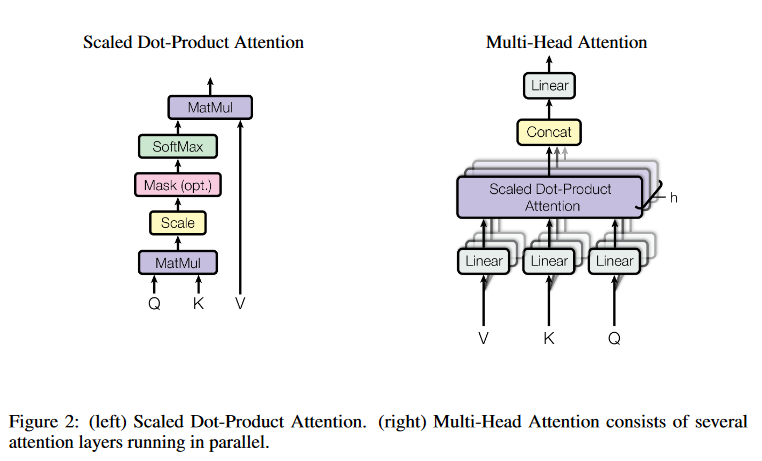

In [104]:
class SelfAttention(nn.Module):   #multi-head attention
  def __init__(self, num_heads, embedding_size, heads_dim ):
    super(SelfAttention, self).__init__()
    self.heads = num_heads  #8
    self.embed = embedding_size  #256
    self.head_dim = heads_dim    #heads_dim = (256/8) or (embedding_size//num_heads) here 32

    self.values_fc = nn.Linear(self.head_dim, self.head_dim)
    self.keys_fc = nn.Linear(self.head_dim, self.head_dim)
    self.queries_fc = nn.Linear(self.head_dim, self.head_dim)

    self.final_out = nn.Linear(self.embed, self.embed)

  def forward(self, key, value, query):
    #key: (N,7,256)  value: (N,7,256)   query: (N,7,256) 7 depends upon the length of input. Here it is 7
    #reshaping
    key = key.reshape(key.shape[0], key.shape[1], self.heads, self.head_dim)  #(N,7,8,32)
    value = value.reshape(value.shape[0], value.shape[1], self.heads, self.head_dim)
    query = query.reshape(query.shape[0], query.shape[1], self.heads, self.head_dim)

    value = self.values_fc(value)
    key = self.keys_fc(key)
    query = self.queries_fc(query)

    #MatMul between query and key

    matmul = torch.einsum("nshd,nkhd->nhsk", [query, key])  #(N,8,7,7)
    

    #softmax
    attn = torch.softmax(matmul/(self.embed**(0.5)), dim = 3)  #(N,8,7,7)
    

    #MatMul between attn and value
    matmul_final = torch.einsum("nhql,nlhd->nqhd", [attn, value])  #(N,7,8,32)
    

    #scaled dot product attention part is done 
    #concatention
    out = matmul_final.reshape(value.shape[0], value.shape[1], -1)  #(N,7,256)

    return out


In [105]:
model = SelfAttention(8,256,32)

In [106]:
inputt = torch.ones((3,7,256), dtype= torch.float32)

In [107]:
o = model(inputt, inputt, inputt)

In [108]:
o.shape

torch.Size([3, 7, 256])

#Encoder Block

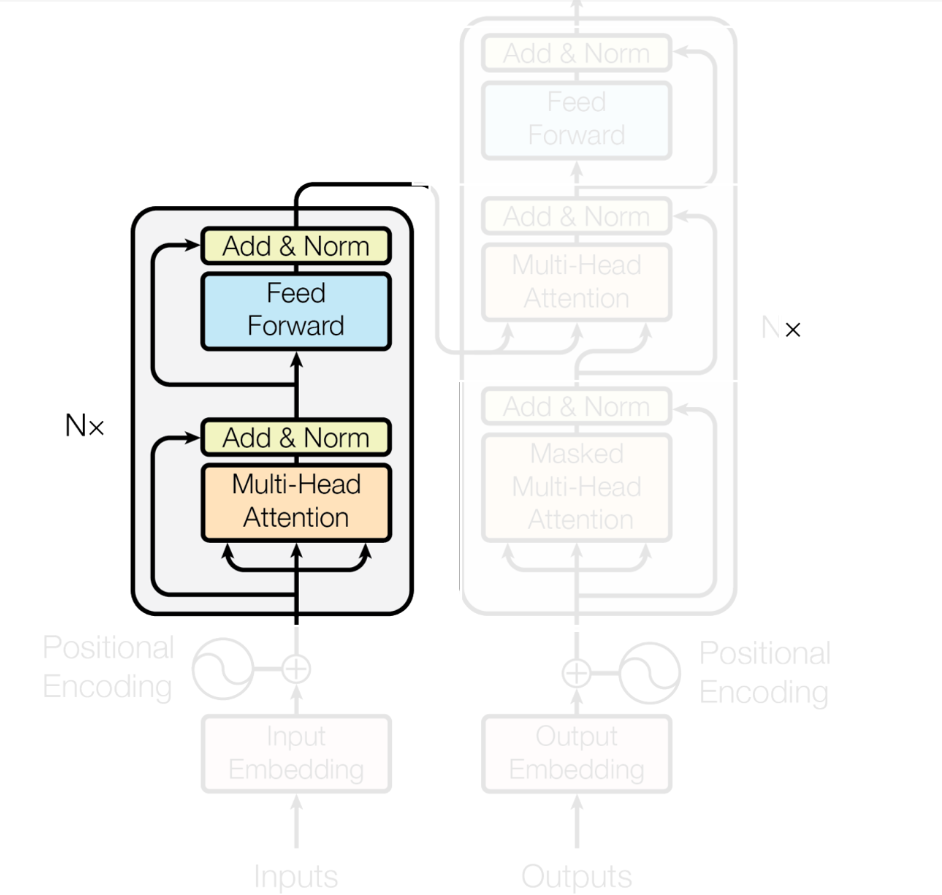

In [109]:
class transformer_encoder_block(nn.Module):
  def __init__(self, num_heads, embedding_size, heads_dim, forward_expansion ):
    super(transformer_encoder_block, self).__init__()
    self.attention = SelfAttention(num_heads, embedding_size, heads_dim)

    self.layer_norm1 = nn.LayerNorm(embedding_size)
    self.layer_norm2 = nn.LayerNorm(embedding_size)

    #feed forward netrwork
    self.feed_forward = nn.Sequential(
        nn.Linear(embedding_size, forward_expansion*embedding_size ),
        nn.ReLU(),
        nn.Linear(forward_expansion*embedding_size, embedding_size )
    )

  def forward(self, key, value, query):
    attn = self.attention(key, value, query)

    #skip connection + layernorm
    out = attn + value
    out = self.layer_norm1(out)

    #feed forward + skip connection + layer norm
    outff = self.feed_forward(out)
    out = out + outff
    out = self.layer_norm2(out)

    return out


In [110]:
inputt = torch.ones((3,7,256), dtype= torch.float32)

In [111]:
tf = transformer_encoder_block(8,256,32,4)

In [112]:
o = tf(inputt, inputt, inputt)

In [113]:
o.shape

torch.Size([3, 7, 256])

#Complete Encoder (with multiple encoder layers)

In [114]:
class encoder(nn.Module):
  def __init__(self, num_heads, embedding_size, heads_dim, forward_expansion, DEVICE , 
               dict_size, input_length, num_layer):
    super(encoder, self).__init__()
    self.num_heads = num_heads
    self.embedding_size = embedding_size
    self.heads_dim = heads_dim
    self.forward_expansion = forward_expansion
    self.DEVICE = DEVICE  

    #word embeddings and position embeddings:
    self.word_embeddings = nn.Embedding(dict_size, embedding_size )  # embedding_size = 256
    self.position_embeddings = nn.Embedding(input_length, embedding_size )  #input_length = 7

    self.network = nn.ModuleList( [ transformer_encoder_block(num_heads, embedding_size, heads_dim, forward_expansion) for i in range(num_layer)])


  def forward(self, input):
    word = torch.arange(0,input.shape[1]).expand(input.shape[0],input.shape[1]).to(self.DEVICE)
    out = self.word_embeddings(input) + self.position_embeddings(word)   #(N,7,256)
    
    for layer in self.network:
      out = layer(out, out, out)
    
    #out shape = (N,7,256)

    return out





In [115]:
e = encoder( num_heads = 8, embedding_size = 256, heads_dim = 32, 
            forward_expansion = 4, DEVICE = DEVICE , dict_size = 104, input_length = 7, num_layer=1).to(DEVICE)
print()

#Decoder Block

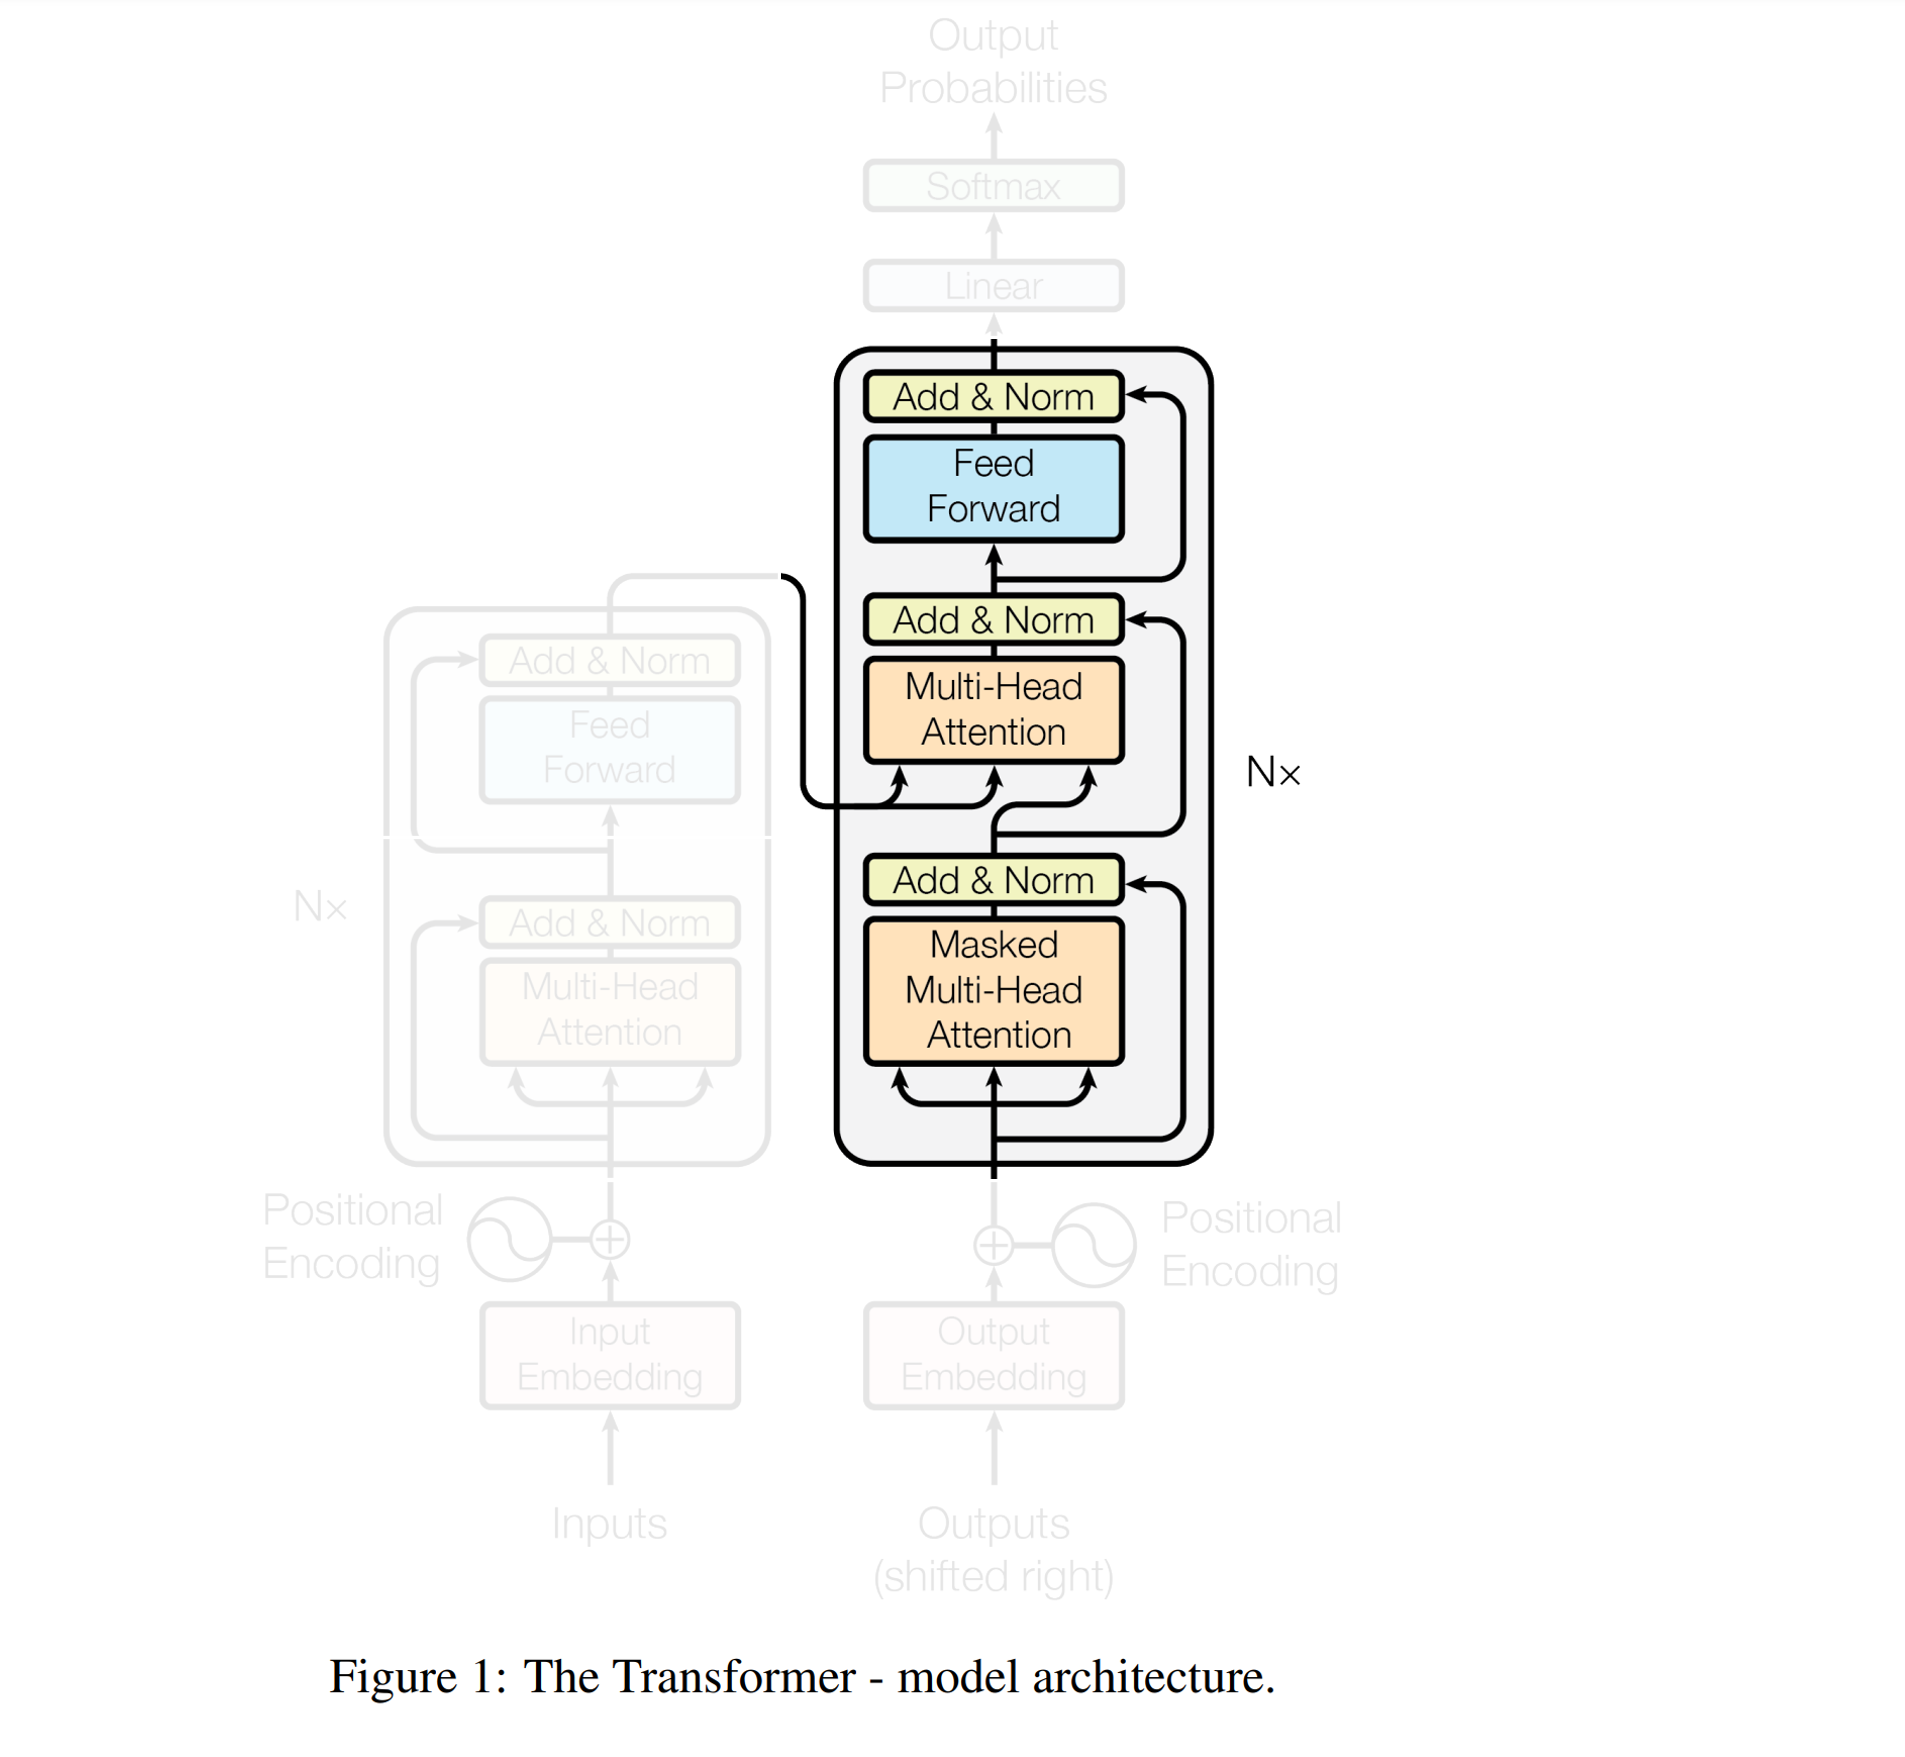

In [116]:
class decoder_unit(nn.Module):
  def __init__(self, num_heads, embedding_size, heads_dim, forward_expansion ):
    super(decoder_unit, self).__init__()
    self.attention = SelfAttention(num_heads, embedding_size, heads_dim)
    self.layer_norm = nn.LayerNorm(embedding_size)

    #transformer part same as encoder
    self.transformer = transformer_encoder_block(num_heads, embedding_size, heads_dim, forward_expansion )

  def forward(self, input, encode_in ):
    attn = self.attention(input, input, input)
    out = self.layer_norm(attn + input)
    out = self.transformer(encode_in, out, encode_in)  #value is key and value and query is out
    
    return out


In [117]:
d = decoder_unit(num_heads=8, embedding_size = 256, heads_dim=32, forward_expansion=4)

In [118]:
i = torch.ones((3,7,256))

In [119]:
o = d(i,i)

In [120]:
o.shape

torch.Size([3, 7, 256])

#Complete decoder (with multiple decoder blocks)

In [121]:
class decoder(nn.Module):
  def __init__(self,num_heads, embedding_size, heads_dim, 
               forward_expansion, DEVICE, target_size , num_layers, dict_size):
    super(decoder, self).__init__()
    self.DEVICE = DEVICE
    self.embedding_size = embedding_size

    self.word_embedding = nn.Embedding(dict_size, embedding_size)  #target_size = 4
    self.position_embeddings = nn.Embedding(target_size, embedding_size)

    self.network = nn.ModuleList(
        [decoder_unit(num_heads, embedding_size, heads_dim, forward_expansion) for i in range(num_layers)]
    )

    self.fc = nn.Linear(embedding_size,dict_size)

  def forward(self,input , encode):
    word = torch.arange(0,input.shape[1]).expand(input.shape[0],input.shape[1]).to(self.DEVICE)
    out = self.word_embedding(input) + self.position_embeddings(word)   #(N,4,256)

    for layer in self.network:
      out = layer(out, encode)   #input is value
    out = self.fc(out) 

    return out



In [122]:
d = decoder(num_heads = 8, embedding_size = 256, heads_dim = 32, forward_expansion = 4, 
            DEVICE = DEVICE, target_size = 7 , num_layers = 10, dict_size = 104).to(DEVICE)

In [123]:
i1 = torch.ones((3,7,256), device = DEVICE)
i2 = torch.ones((3,7), device = DEVICE, dtype = torch.int32)
o = d(i2, i1)

In [124]:
o.shape

torch.Size([3, 7, 104])

#Final Transformer

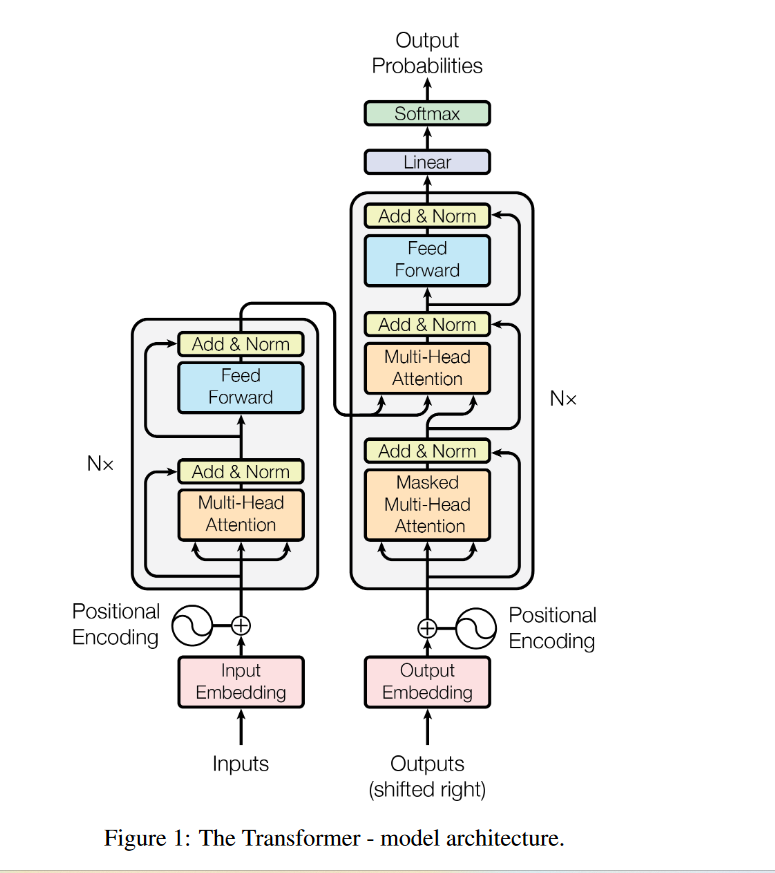

In [125]:
class Transformer(nn.Module):
  def __init__(self,num_heads, embedding_size, heads_dim, forward_expansion, 
               DEVICE, target_size , dict_size, num_layer_encoder, 
               num_layer_decoder, input_length):
    super(Transformer, self).__init__()
    self.DEVICE = DEVICE
    self.encoder = encoder(num_heads, embedding_size, heads_dim, forward_expansion, DEVICE , 
               dict_size, input_length, num_layer_encoder)
    
    self.decoder = decoder(num_heads, embedding_size, heads_dim, forward_expansion, DEVICE, 
                           target_size , num_layer_decoder, dict_size)
    
  def forward(self, input, output_shifted):
    #input = (N,7)
    out = self.encoder(input)

    out = self.decoder(output_shifted , out)

    return out


In [126]:
transformer_model = Transformer(num_heads = 8, embedding_size = 256, heads_dim = 32, forward_expansion = 4, 
               DEVICE = DEVICE, target_size = 7 , dict_size = 104, num_layer_encoder = 4, 
               num_layer_decoder = 4, input_length = 7 ).to(DEVICE)

               #num_layer_encoder, num_layer_decoder, num_heads, embedding_size, forward_expansion are hyperparameters

In [127]:
inp = torch.ones((3,7), dtype = torch.int32, device= DEVICE)

In [128]:
out = transformer_model(inp, inp)   #(X,inp)

In [129]:
type(out)

torch.Tensor

#defining some important stuffs required for training:

In [130]:
from torch.utils.data import Dataset, DataLoader

input = torch.tensor(input, dtype = torch.int32, device = DEVICE)
output = torch.tensor(output, dtype = torch.int32, device = DEVICE)

ycat = torch.zeros((5000,3), device= DEVICE, dtype = torch.int32)
output = torch.cat((output, ycat), dim=1)

class CustomImageDataset(Dataset):   
    def __init__(self, input, output):
        self.images = input
        self.masks = output

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        x_batch = self.images[idx]
        y_batch = self.masks[idx]
        return x_batch, y_batch

In [131]:
data = CustomImageDataset(input, output)

In [132]:
batchsize = 100
dataloader = DataLoader(dataset= data, batch_size= batchsize, shuffle= True)

In [133]:
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.001)        #update the weights of the model 
loss_type = torch.nn.CrossEntropyLoss()
step_lr = lr_scheduler.StepLR(optimizer, step_size= 100, gamma = 0.5)  #Learning rate schedular

#Training the network

In [134]:
#Model Training
loss_graph = []
num_epochs = 100   

inp = torch.ones((batchsize,7), dtype = torch.int32, device= DEVICE)
path_folder = '/content/drive/MyDrive/DL/saved_weights/transformer'
for j in range(num_epochs):

  transformer_model.train()
  for i, (x_batch, y_batch) in enumerate(dataloader):
    optimizer.zero_grad()
    y_pred = transformer_model(x_batch, inp)
    

    y_pred = y_pred.reshape(-1,104)  #104 is dictionary size
    y_batch = y_batch.reshape(-1)
    y_batch = y_batch.type(torch.LongTensor).to(DEVICE)
  
    loss = loss_type(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    loss_graph.append(loss.cpu().item())

    """if i%40 ==0:
      print("Loss is: ", loss.item())"""

    #schedular step
    #step_lr.step()
  if (j+1)%10 == 0:
    PATH = os.path.join(path_folder, 'model_transformer' + str(j+1)+ '.pth')
    torch.save(transformer_model.state_dict(), PATH)
  print("Epoch: ", j+1, ", loss is: ", loss.cpu().item())
  

Epoch:  1 , loss is:  0.7324358224868774
Epoch:  2 , loss is:  0.7221689820289612
Epoch:  3 , loss is:  0.7178257703781128
Epoch:  4 , loss is:  0.7092142105102539
Epoch:  5 , loss is:  0.7093849182128906
Epoch:  6 , loss is:  0.7214483022689819
Epoch:  7 , loss is:  0.7131108045578003
Epoch:  8 , loss is:  0.6895718574523926
Epoch:  9 , loss is:  0.6947924494743347
Epoch:  10 , loss is:  0.6747826337814331
Epoch:  11 , loss is:  0.6375312209129333
Epoch:  12 , loss is:  0.6030538082122803
Epoch:  13 , loss is:  0.5770438313484192
Epoch:  14 , loss is:  0.5569368004798889
Epoch:  15 , loss is:  0.5652070641517639
Epoch:  16 , loss is:  0.5195991396903992
Epoch:  17 , loss is:  0.5053474307060242
Epoch:  18 , loss is:  0.5416823625564575
Epoch:  19 , loss is:  0.49525704979896545
Epoch:  20 , loss is:  0.47350817918777466
Epoch:  21 , loss is:  0.4774274230003357
Epoch:  22 , loss is:  0.45666125416755676
Epoch:  23 , loss is:  0.478531152009964
Epoch:  24 , loss is:  0.4632974267005920

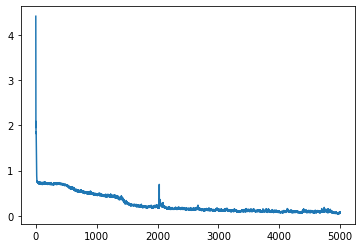

In [135]:
#Loss curve:
plt.plot(loss_graph)
plt.show()

#Prediction using the trained model (overfitted results):

In [136]:
def sentences(inputnums):
  ans = ''
  for i in inputnums:
    for j in map_dict:
      if i == map_dict[j]:
        ans += (j + ' ')

  return ans

In [137]:
inp = torch.ones((2,7), dtype = torch.int32, device= DEVICE)
input_temp = input[0:2]
out_temp = transformer_model(input_temp, inp)

In [138]:
print("Output predicted by model: ", torch.argmax(out_temp[0], axis=1))
print("Actual Output: ", output[0])

Output predicted by model:  tensor([ 0, 10, 16,  5,  0,  0,  0], device='cuda:0')
Actual Output:  tensor([ 0, 10, 16,  5,  0,  0,  0], device='cuda:0', dtype=torch.int32)


In [139]:
#Output sentences:
print("Actual output sentence: ", sentences(output[0]))
print("Predicted output sentences: ",sentences(torch.argmax(out_temp[0], axis=1)) )

Actual output sentence:  BOS POSITIVE 04 EOS BOS BOS BOS 
Predicted output sentences:  BOS POSITIVE 04 EOS BOS BOS BOS 
